In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt

df = pd.read_csv('smart_synthetic_network_data_10years.csv')
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df = df.sort_index()
df.head()


,Connected Clients,Chipset Temp,Supply Voltage,Packet Loss,Network Congestion,Jitter,RSSI,SNR,Temperature,Humidity
Time,,,,,,,,,,
2013-01-01 00:00:00,22.48,18.05,3.307,1.36,42.90,6.83,-52.73,22.92,19.26,77.29
2013-01-01 01:00:00,19.32,18.91,3.299,2.18,40.70,3.75,-51.31,23.18,18.25,73.91
2013-01-01 02:00:00,23.26,25.18,3.295,1.53,35.45,2.93,-52.89,21.34,20.77,68.02
2013-01-01 03:00:00,27.65,26.74,3.297,2.40,43.87,4.79,-57.01,25.68,21.08,74.74
2013-01-01 04:00:00,18.88,21.10,3.287,2.47,37.68,5.73,-52.53,23.71,18.50,81.26


In [75]:
# Resampling
daily_humidity = df['Humidity'].resample('D').mean()

In [76]:
# Preprocessing

#Missing Values
print("Missing values before filling:", daily_humidity.isnull().sum())
daily_humidity = daily_humidity.fillna(method='ffill')  # Forward fill
daily_humidity = daily_humidity.fillna(method='bfill')  # Backward fill if any left
print("Missing values after filling:", daily_humidity.isnull().sum())

# Handling Outliers
# Using IQR (Interquartile Range) method
Q1 = daily_humidity.quantile(0.25)
Q3 = daily_humidity.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clip outliers to the lower and upper bounds
daily_humidity = daily_humidity.clip(lower=lower_bound, upper=upper_bound)

# 3. Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
daily_humidity_scaled = scaler.fit_transform(daily_humidity.values.reshape(-1, 1))
daily_humidity_scaled = pd.Series(daily_humidity_scaled.flatten(), index=daily_humidity.index)


Missing values before filling: 0
Missing values after filling: 0


In [77]:

# Check Stationarity
def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    print(out)
    if result[1] <= 0.05:
        print("=> Stationary ✅")
    else:
        print("=> Non-Stationary ❌")

adf_test(daily_humidity, 'Original Humidity Series')

ADF Test: Original Humidity Series
ADF Test Statistic            -1.584436e+01
p-value                        9.610221e-29
#Lags Used                     3.000000e+01
Number of Observations Used    3.619000e+03
dtype: float64
=> Stationary ✅


In [78]:
# If Non-Stationary, Difference it
if adfuller(daily_humidity.dropna())[1] > 0.05:
    print("\nApplying Differencing to make data Stationary...")
    daily_humidity = daily_humidity.diff().dropna()
    adf_test(daily_humidity, 'After Differencing')

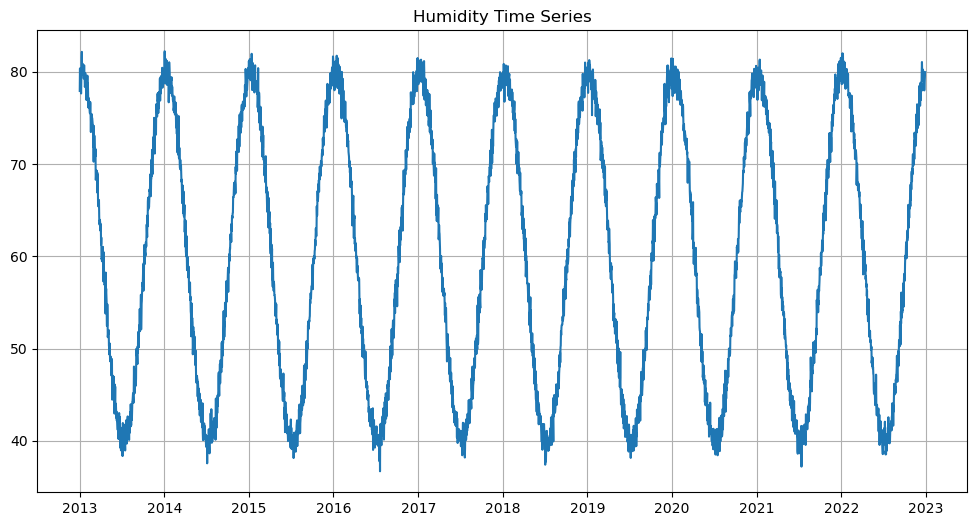

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(daily_humidity)
plt.title('Humidity Time Series')
plt.grid(True)
plt.show()

C:\Users\PRIYANSHU BARDHAN\AppData\Local\Temp\ipykernel_16736\2644686530.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


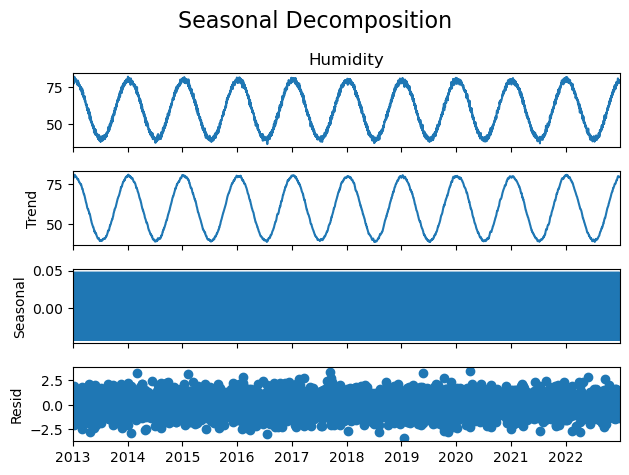

In [80]:
decomposition = seasonal_decompose(daily_humidity, model='additive')
decomposition.plot()
plt.suptitle('Seasonal Decomposition', fontsize=16)
plt.tight_layout()
plt.show()


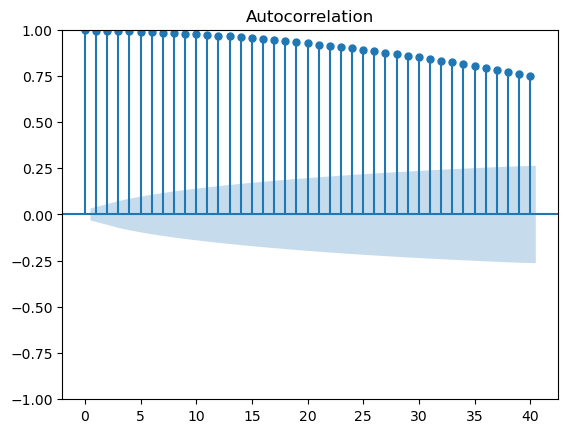

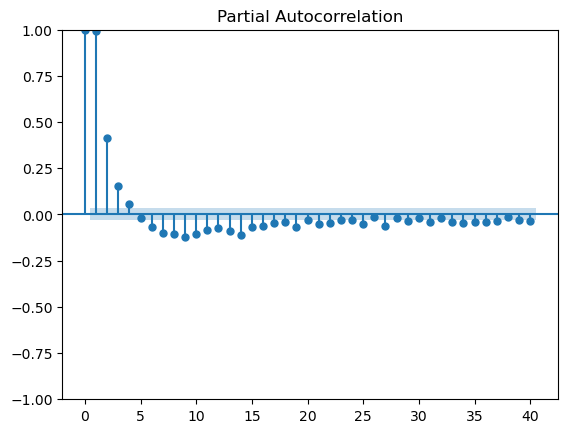

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(daily_humidity, lags=40)
plt.show()
plot_pacf(daily_humidity, lags=40)
plt.show()


In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def detect_seasonality(series, threshold=0.05, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    # Calculate strength of seasonality
    seasonal_strength = (seasonal.var() / series.var())
    print(f"Seasonality Strength: {seasonal_strength:.4f}")

    if seasonal_strength > threshold:
        print("✅ Data is Seasonal")
        return True
    else:
        print("❌ Data is Non-Seasonal")
        return False

# Example usage
is_seasonal = detect_seasonality(daily_humidity)


Seasonality Strength: 0.0000
❌ Data is Non-Seasonal


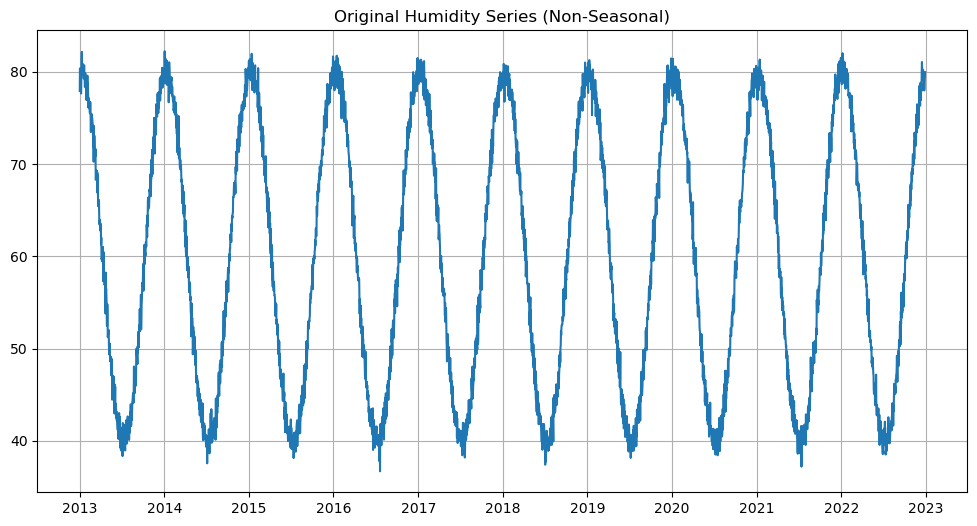

In [61]:
if is_seasonal:
    # Apply seasonal differencing
    seasonal_diff = daily_humidity.diff(12).dropna()

    # Plot the differenced series
    plt.figure(figsize=(12, 6))
    plt.plot(seasonal_diff)
    plt.title('Seasonally Differenced Humidity')
    plt.grid(True)
    plt.show()
else:
    # If not seasonal, plot original
    plt.figure(figsize=(12, 6))
    plt.plot(daily_humidity)
    plt.title('Original Humidity Series (Non-Seasonal)')
    plt.grid(True)
    plt.show()

In [62]:
if not is_seasonal:
    split_index = int(len(daily_humidity) * 0.8)
    train = daily_humidity.iloc[:split_index]
    test = daily_humidity.iloc[split_index:]
else:
    split_index = int(len(seasonal_diff) * 0.8)
    train = seasonal_diff.iloc[:split_index]
    test = seasonal_diff.iloc[split_index:]


# # ------------------- ARIMA -------------------
# arima_model = ARIMA(train, order=(0, 1, 1))  # (p,d,q) - you can tune later
# arima_result = arima_model.fit()

# # Forecast
# arima_forecast = arima_result.forecast(steps=len(test))



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=9717.891, Time=9.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=23775.009, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10454.756, Time=5.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=17891.415, Time=1.91 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=32356.252, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=9602.629, Time=6.20 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=9654.827, Time=2.62 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=9555.049, Time=14.78 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=9739.405, Time=23.89 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=9512.978, Time=8.45 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=9552.561, Time=3.31 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=18.54 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=9689.858, Time=4.11 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=15075.788, Time=10.14 sec
 ARIMA(1,0,1)(0

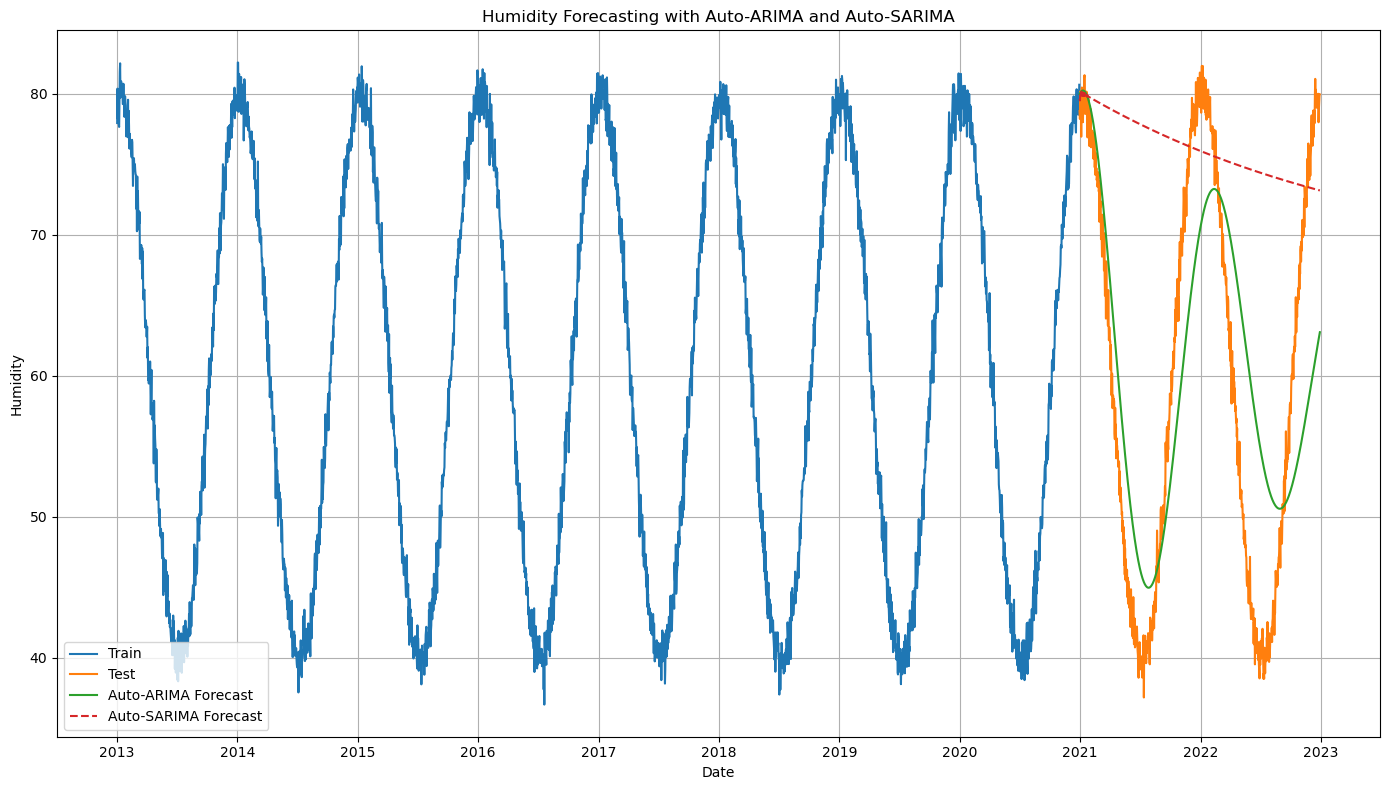

In [ ]:
# ------------------- Auto-ARIMA Model -------------------
from pmdarima import auto_arima
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Auto-ARIMA will find best (p,d,q) and (P,D,Q,m) automatically
auto_arima_model = auto_arima(train,
                        seasonal=True,
                        m=12,              # 12 = monthly seasonality
                        trace=True,        
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

# Summary of the best Auto-ARIMA model
print("\n--- Auto-ARIMA Model Summary ---")
print(auto_arima_model.summary())

# Forecast
n_periods = len(test)
auto_arima_forecast = auto_arima_model.predict(n_periods=n_periods)

# Evaluation
auto_arima_rmse = np.sqrt(mean_squared_error(test, auto_arima_forecast))
auto_arima_mae = mean_absolute_error(test, auto_arima_forecast)
auto_arima_mape = np.mean(np.abs((test - auto_arima_forecast) / test)) * 100
auto_arima_r2 = r2_score(test, auto_arima_forecast)


# ------------------- Auto-SARIMA Model -------------------
# SARIMA is ARIMA + Seasonality terms
auto_sarima_model = auto_arima(train,
                        seasonal=True,
                        m=12,
                        start_p=0, start_q=0,
                        max_p=3, max_q=3,
                        start_P=0, start_Q=0,
                        max_P=2, max_Q=2,
                        d=None, D=None,           # Auto-differencing
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        information_criterion='aic')  # Based on AIC

# Summary of best Auto-SARIMA model
print("\n--- Auto-SARIMA Model Summary ---")
print(auto_sarima_model.summary())

# Forecast
auto_sarima_forecast = auto_sarima_model.predict(n_periods=n_periods)

# Evaluation
auto_sarima_rmse = np.sqrt(mean_squared_error(test, auto_sarima_forecast))
auto_sarima_mae = mean_absolute_error(test, auto_sarima_forecast)
auto_sarima_mape = np.mean(np.abs((test - auto_sarima_forecast) / test)) * 100
auto_sarima_r2 = r2_score(test, auto_sarima_forecast)

print("\n--- Auto-ARIMA Model Evaluation ---")
print(f"RMSE: {auto_arima_rmse:.4f}")
print(f"MAE: {auto_arima_mae:.4f}")
print(f"MAPE: {auto_arima_mape:.2f}%")
print(f"R² Score: {auto_arima_r2:.4f}")

print("\n--- Auto-SARIMA Model Evaluation ---")
print(f"RMSE: {auto_sarima_rmse:.4f}")
print(f"MAE: {auto_sarima_mae:.4f}")
print(f"MAPE: {auto_sarima_mape:.2f}%")
print(f"R² Score: {auto_sarima_r2:.4f}")

# ------------------- Plotting -------------------
plt.figure(figsize=(14, 8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, auto_arima_forecast, label='Auto-ARIMA Forecast')
plt.plot(test.index, auto_sarima_forecast, label='Auto-SARIMA Forecast', linestyle='--')
plt.title('Humidity Forecasting with Auto-ARIMA and Auto-SARIMA')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error
import numpy as np

print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, auto_arima_forecast)))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test, auto_sarima_forecast)))


ARIMA RMSE: 9.088823293676471
SARIMA RMSE: 21.539859572767266


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics
arima_rmse = sqrt(mean_squared_error(test, auto_arima_forecast))
arima_mae = mean_absolute_error(test, auto_arima_forecast)
arima_mape = np.mean(np.abs((test - auto_arima_forecast) / test)) * 100
arima_r2 = r2_score(test, auto_arima_forecast)

sarima_rmse = sqrt(mean_squared_error(test, auto_sarima_forecast))
sarima_mae = mean_absolute_error(test, auto_sarima_forecast)
sarima_mape = np.mean(np.abs((test - auto_sarima_forecast) / test)) * 100
sarima_r2 = r2_score(test, auto_sarima_forecast)

# Print results
print("--- ARIMA Model Evaluation ---")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAE: {arima_mae:.4f}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"R² Score: {arima_r2:.4f}")
print()
print("--- SARIMA Model Evaluation ---")
print(f"RMSE: {sarima_rmse:.4f}")
print(f"MAE: {sarima_mae:.4f}")
print(f"MAPE: {sarima_mape:.2f}%")
print(f"R² Score: {sarima_r2:.4f}")


--- ARIMA Model Evaluation ---
RMSE: 9.0888
MAE: 7.6140
MAPE: 13.63%
R² Score: 0.5899

--- SARIMA Model Evaluation ---
RMSE: 21.5399
MAE: 17.2982
MAPE: 36.12%
R² Score: -1.3032


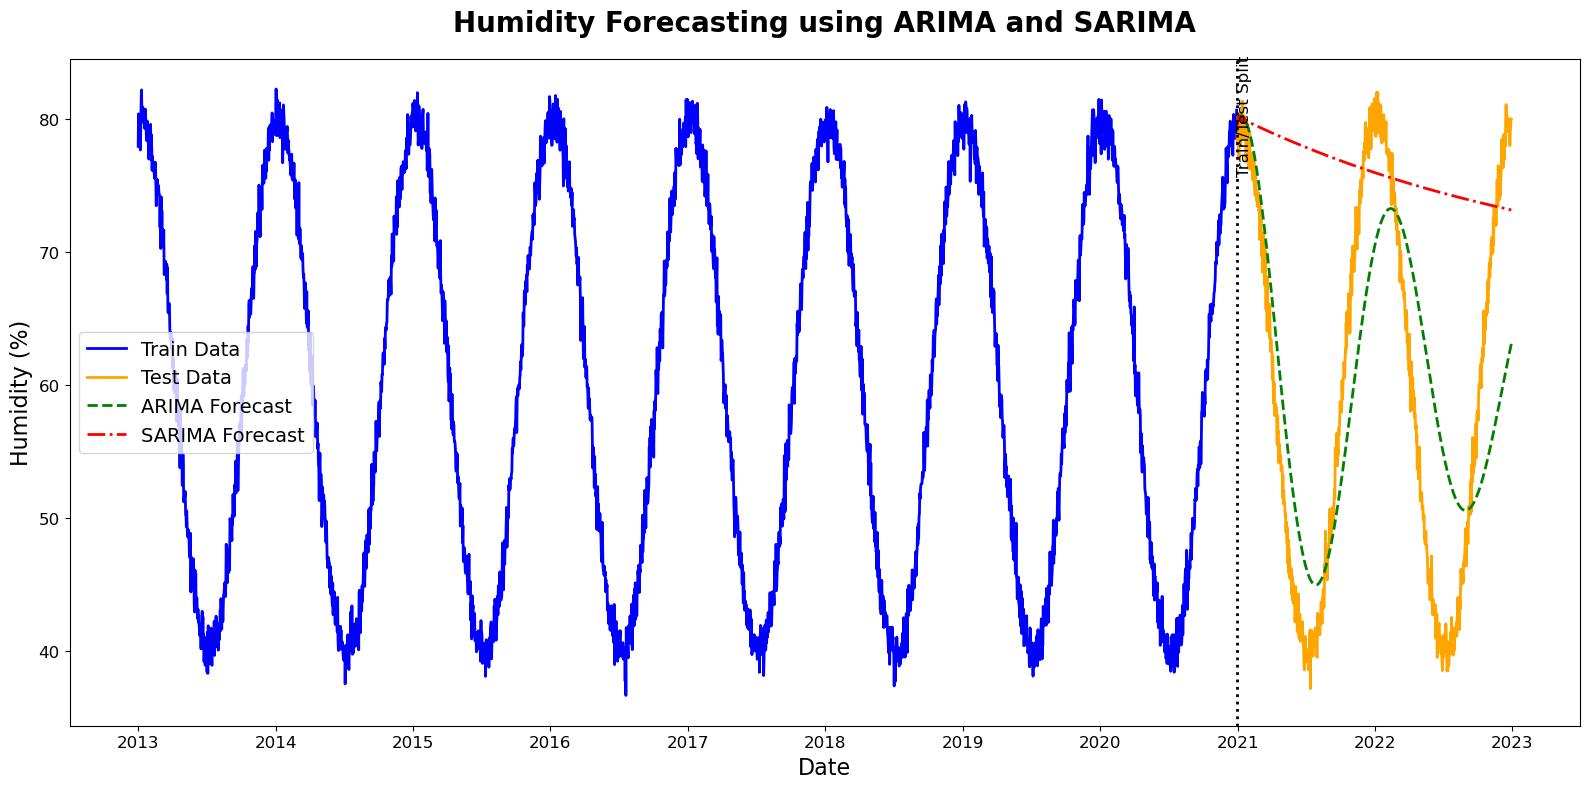

In [68]:
# ------------------- Combined Plot (Train, Test, ARIMA, SARIMA) -------------------
plt.figure(figsize=(16, 8))

# Plot Train Data
plt.plot(train.index, train, label='Train Data', color='blue', linewidth=2)

# Plot Test Data
plt.plot(test.index, test, label='Test Data', color='orange', linewidth=2)

# Plot ARIMA Forecast
plt.plot(test.index, auto_arima_forecast, label='ARIMA Forecast', color='green', linestyle='--', linewidth=2)

# Plot SARIMA Forecast
plt.plot(test.index, auto_sarima_forecast, label='SARIMA Forecast', color='red', linestyle='-.', linewidth=2)

# Add shaded area for Train/Test split
plt.axvline(x=test.index[0], color='black', linestyle=':', lw=2)
plt.text(test.index[0], plt.ylim()[1]*0.95, 'Train/Test Split', rotation=90, verticalalignment='center', fontsize=12)

# Titles and labels
plt.title('Humidity Forecasting using ARIMA and SARIMA', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Humidity (%)', fontsize=16)

# Ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend
plt.legend(fontsize=14, loc='best', frameon=True)

# Tight layout
plt.tight_layout()

# Show plot
plt.show()


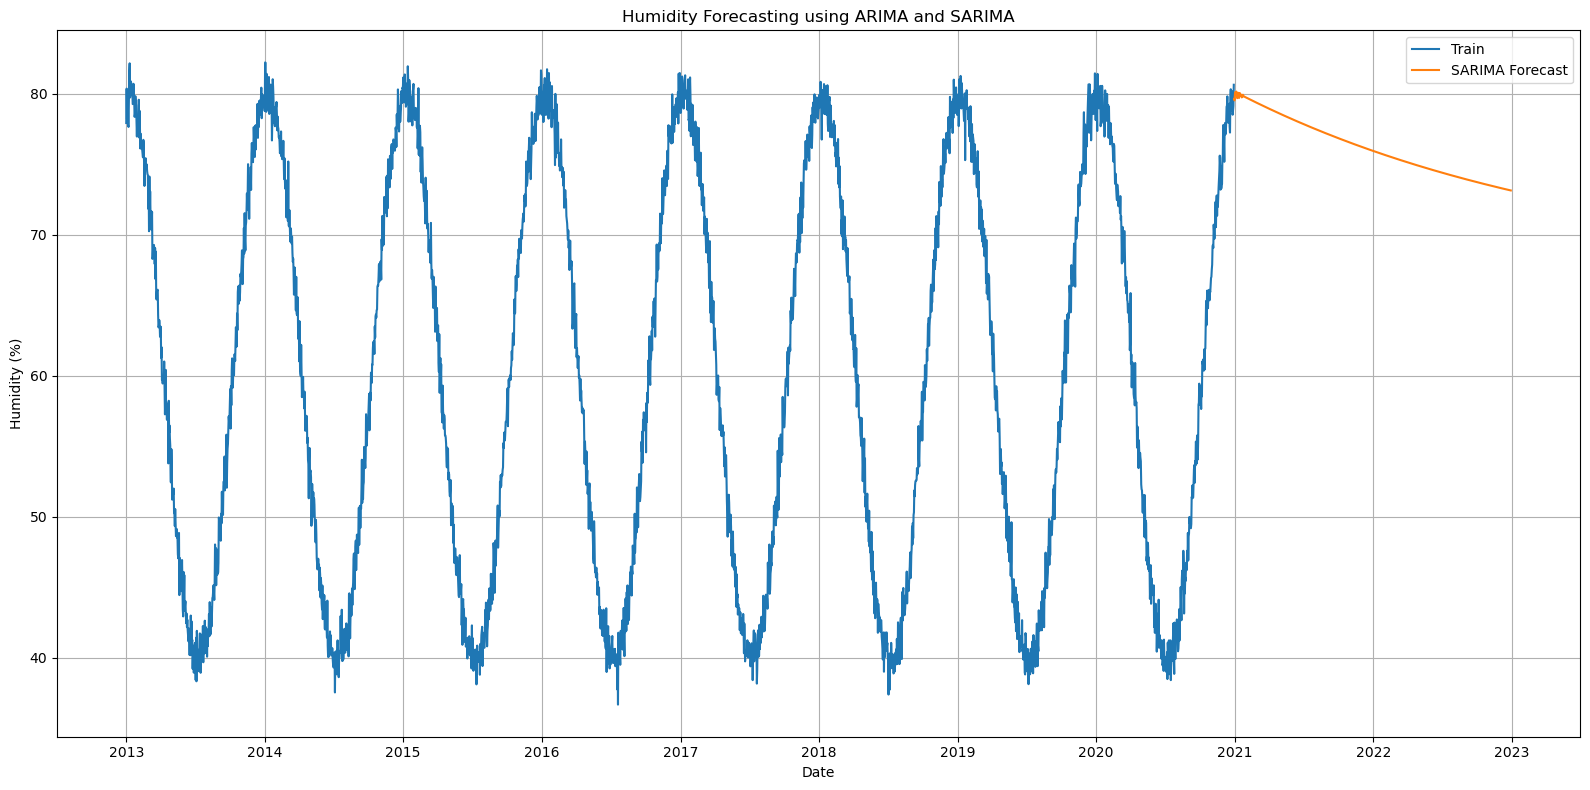

In [70]:
# ------------------- Plotting -------------------
plt.figure(figsize=(16, 8))
plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Test')
# plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, auto_sarima_forecast, label='SARIMA Forecast')
plt.title('Humidity Forecasting using ARIMA and SARIMA')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()